## Visualize CNN Weights & Activiations

### 1. Import Libraries

In [36]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K

%matplotlib inline

### 2. Helper Functions

In [9]:
def tensor_summary(tensor):
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))
    
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

### 3. Build VGG16 Convolutional Network

In [11]:
model = vgg16.VGG16(weights='imagenet')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 4. Test the Model with RGB Image

shape: (224, 224, 3)  min: 0  max: 255


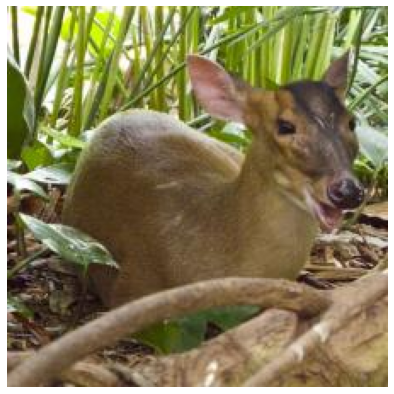

In [14]:
image = skimage.io.imread("http://lorempixel.com/224/224/animals/")
assert image.shape == (224, 224, 3), "Must be 224*224 RGB Image"
tensor_summary(image)
display_images([image], cols=2)

In [15]:
x = image.astype(np.float32)

x = x[np.newaxis,...]

x = vgg16.preprocess_input(x)

In [16]:
predictions = model.predict(x)

print(predictions[0][:10])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp_9kt3_m1.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp_9kt3_m1.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[1.7016853e-06 7.6810977e-07 1.9622968e-07 1.0975580e-07 1.5861352e-07
 1.8958758e-06 1.8892646e-06 6.4031715e-06 2.1029840e-05 2.3465527e-06]


In [18]:
label_index = np.argmax(predictions)
print("label index: ", label_index)

vgg16.decode_predictions(predictions)

label index:  104


[[('n01877812', 'wallaby', 0.91335267),
  ('n02115913', 'dhole', 0.015239022),
  ('n02422699', 'impala', 0.0072828894),
  ('n02356798', 'fox_squirrel', 0.00664482),
  ('n02125311', 'cougar', 0.006032702)]]

In [19]:
imagenet_classes = keras.applications.imagenet_utils.CLASS_INDEX
for i in range(10):
    print(i, imagenet_classes[str(i)][1])

0 tench
1 goldfish
2 great_white_shark
3 tiger_shark
4 hammerhead
5 electric_ray
6 stingray
7 cock
8 hen
9 ostrich


### 5. Heatmap

In [20]:
step = 56
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(16, 224, 224, 3)

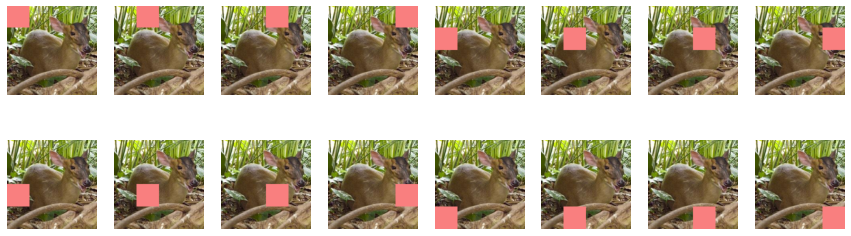

In [21]:
display_images(heatmap_x[:28], cols=8)

In [22]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (16, 1000)  min: 5.726770169189876e-10  max: 0.9773861169815063


In [23]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (16,)  min: 0.11584705859422684  max: 0.9773861169815063


In [24]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
tensor_summary(heatmap)

shape: (4, 4)  min: 0.0  max: 1.0


shape: (4, 4)  min: 0.0  max: 1.0


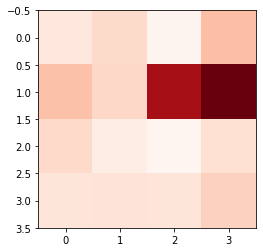

In [25]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

shape: (224, 224, 3)  min: 0.0  max: 203.8920135498047


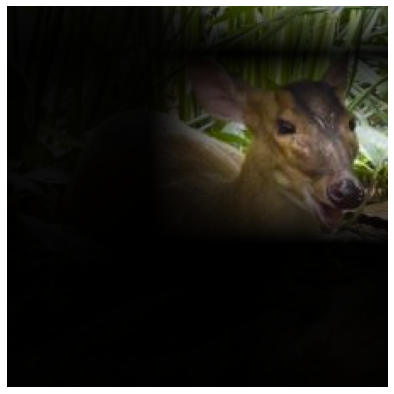

In [26]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


# Apply mask to image
apply_mask(image, heatmap**2)

### 6. Visualize Weights

In [27]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.6085159)

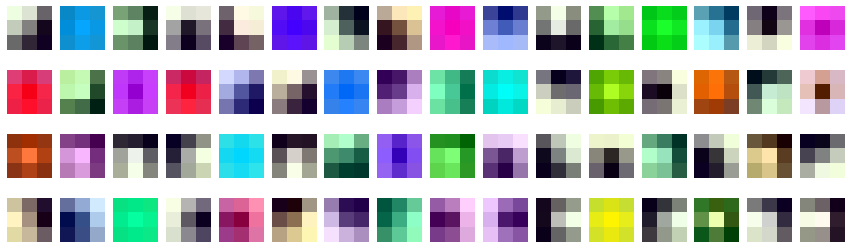

In [28]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation="none")

### 7. Visualize Activations

In [37]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 224, 224, 64)  min: 0.0  max: 649.31591796875


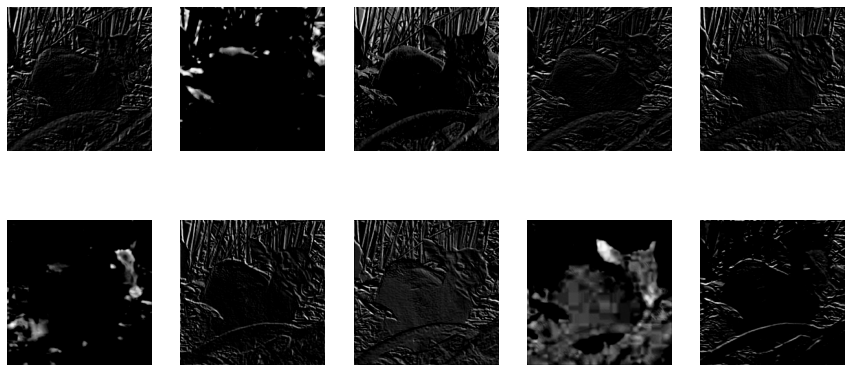

In [38]:
view_layer(model, x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 2667.4921875


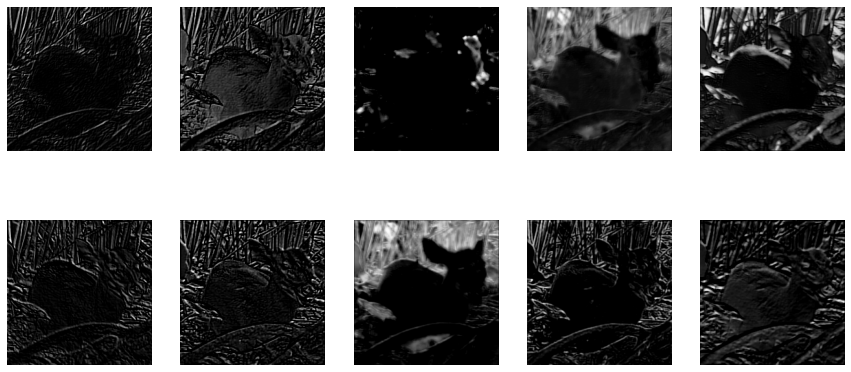

In [39]:
view_layer(model, x, "block1_conv2")

shape: (1, 112, 112, 128)  min: 0.0  max: 4583.91552734375


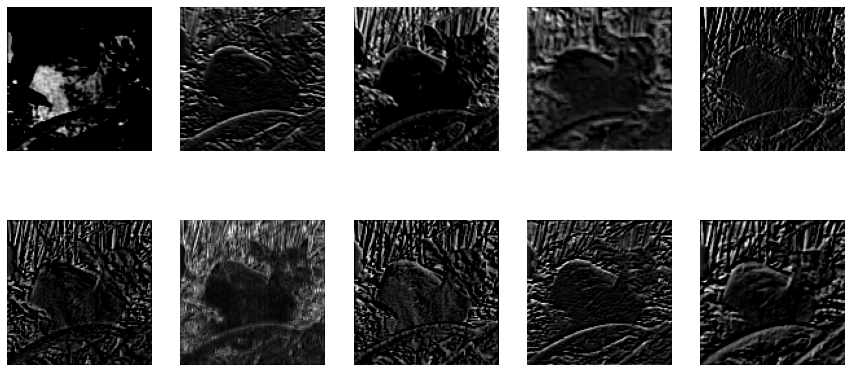

In [40]:
view_layer(model, x, "block2_conv1")

shape: (1, 56, 56, 256)  min: 0.0  max: 10191.3505859375


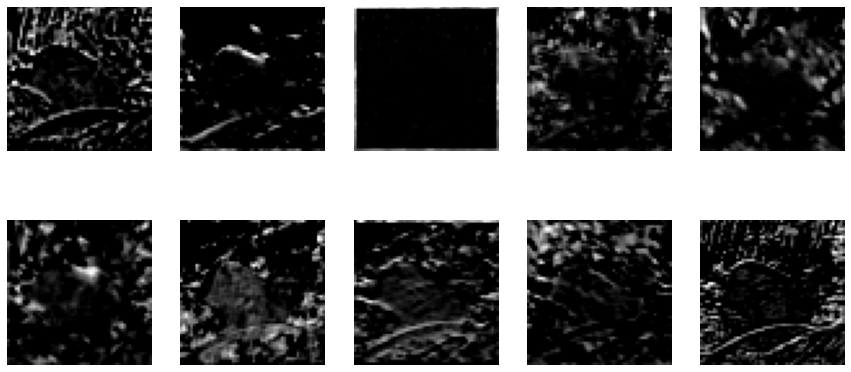

In [41]:
view_layer(model, x, "block3_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 8214.498046875


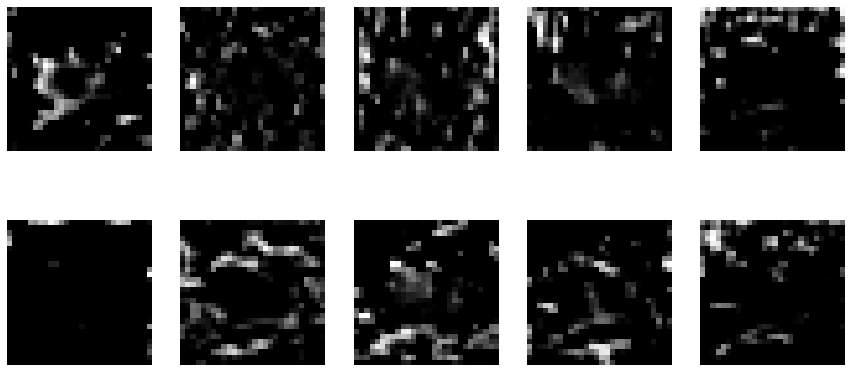

In [42]:
view_layer(model, x, "block4_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 2046.9132080078125
shape: (224, 224, 3)  min: 0.0  max: 231.7638397216797


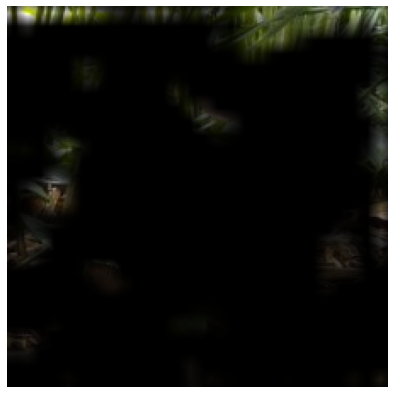

In [44]:
a = read_layer(model, x, "block4_conv3")
apply_mask(image, a[:,:, 0])

shape: (1, 1000)  min: 1.0014658435864021e-08  max: 0.9133526682853699


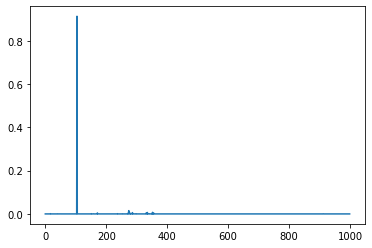

In [46]:
a = read_layer(model, x, "predictions")
_ = plt.plot(a)